In [35]:
___Author___='LumberJack Jyss'

# LSTM for AMZN with memory

In [36]:
print('LSTM FROM KEREAS with memory\nLumberJack Jyss (c)')

LSTM FROM KEREAS with memory
LumberJack Jyss (c)


In [37]:
import numpy
import matplotlib.pyplot as plt
import pandas_datareader as web
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [38]:
# Setting the data
start = pd.to_datetime('2016-03-31')
end = pd.to_datetime('2019-03-28')
delta = round((end-start).days)
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')
print('Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés')

Période d'étude :  1092
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  874  jours 
Bloc 2 : 218  jours
Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés


In [39]:
dataset = web.DataReader('AMZN','yahoo',start,end)
#spy_etf = web.DataReader('SPY','yahoo',start,end)
dataset = dataset.drop(['Low','Close'],axis=1)

In [40]:
print("Longueur du dataset : ",len(dataset))

Longueur du dataset :  754


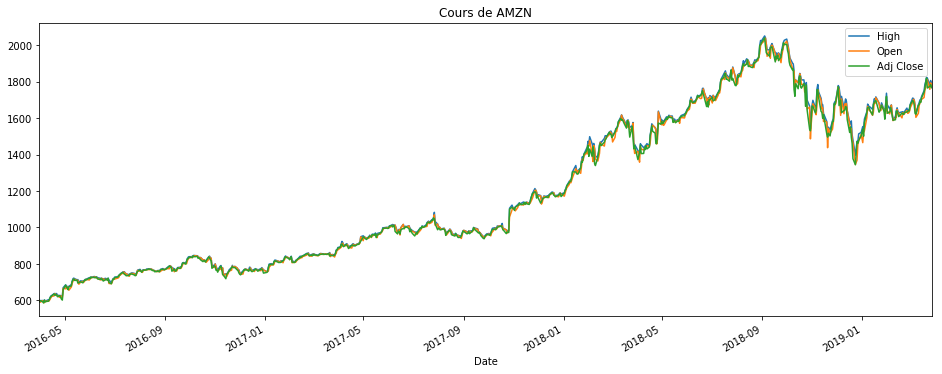

In [41]:
dataset[['High','Open','Adj Close']].plot(figsize=(16,6),title='Cours de AMZN')

In [42]:
print('Nombre de valeurs nulles dans le dataset :')
dataset.isnull().sum().sum()

Nombre de valeurs nulles dans le dataset :


0

In [43]:
print('Informations sur le dataset (sur les colonnes, ainsi que leur type)')
dataset.info()

Informations sur le dataset (sur les colonnes, ainsi que leur type)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2016-03-31 to 2019-03-28
Data columns (total 4 columns):
High         754 non-null float64
Open         754 non-null float64
Volume       754 non-null int64
Adj Close    754 non-null float64
dtypes: float64(3), int64(1)
memory usage: 29.5 KB


In [44]:
# save to file
print('Le fichier est sauvegardé en local sous format csv')
dataset.to_csv('AMZN.csv')

Le fichier est sauvegardé en local sous format csv


In [45]:
print('Début du dataset :\n',dataset.head())
print('Fin du dataset :\n',dataset.tail())

Début du dataset :
                   High        Open   Volume   Adj Close
Date                                                   
2016-03-31  600.750000  599.280029  2681800  593.640015
2016-04-01  599.030029  590.489990  2917400  598.500000
2016-04-04  599.500000  599.000000  2470800  593.190002
2016-04-05  593.469971  590.770020  2308900  586.140015
2016-04-06  602.390015  587.520020  2833500  602.080017
Fin du dataset :
                    High         Open   Volume    Adj Close
Date                                                      
2019-03-22  1818.979980  1810.170044  6363000  1764.770020
2019-03-25  1782.680054  1757.790039  5103800  1774.260010
2019-03-26  1805.770020  1793.000000  4865900  1783.760010
2019-03-27  1787.500000  1784.130005  4324800  1765.699951
2019-03-28  1777.930054  1770.000000  3043000  1773.420044


In [46]:
#print('On transforme le dataframe en arrays par la fonction ".values"')
values = dataset.values
# specify columns to plot

On trace alors les plots des différentes colonnes


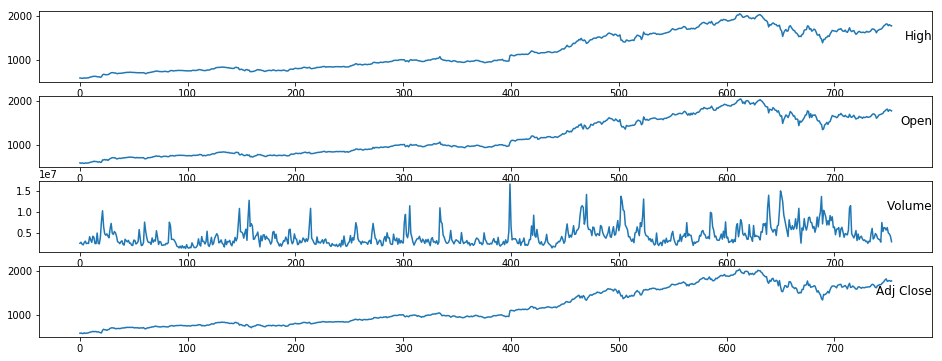

In [47]:
groups = [0, 1, 2, 3]
i = 1
# plot each column
print('On trace alors les plots des différentes colonnes')
plt.figure(figsize=(16,6))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [48]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [52]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('AMZN.csv',engine='python', header=0, index_col=0)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = bloc1
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1,trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0],1,testX.shape[1]))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(10):
	model.fit(trainX, trainY, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

ValueError: Error when checking input: expected lstm_8_input to have shape (3, 1) but got array with shape (1, 3)

No handles with labels found to put in legend.


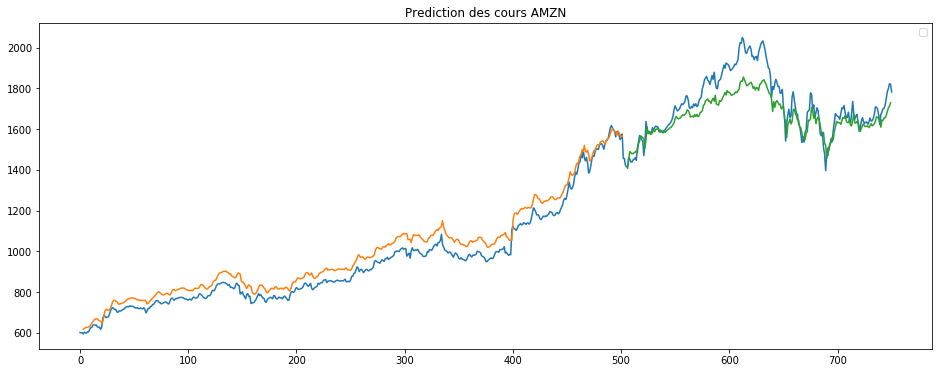

In [8]:
# plot baseline and predictions
plt.figure(figsize=(16,6))
plt.legend()
plt.title('Prediction des cours AMZN')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [9]:
testY

array([[1415.3900422 , 1459.56005601, 1452.50001683, 1438.47998481,
        1438.38002534, 1448.78006557, 1452.11997979, 1459.77994947,
        1446.99998804, 1507.18991802, 1533.7999798 , 1568.52004598,
        1561.1999906 , 1547.99995624, 1539.50001438, 1469.99005803,
        1529.42000076, 1638.10000001, 1595.99995488, 1585.00007099,
        1588.49995509, 1574.80003654, 1584.90002467, 1606.94998931,
        1596.88004981, 1607.99995454, 1615.60000064, 1611.10000077,
        1611.18007256, 1587.79997827, 1594.43013093, 1594.04001978,
        1583.59004324, 1592.05003605, 1589.89000832, 1601.85995935,
        1608.23999622, 1614.11997521, 1621.790019  , 1625.99995403,
        1634.99995378, 1646.73003682, 1665.68012892, 1699.00006776,
        1714.49995153, 1699.89996352, 1689.43991287, 1694.24005169,
        1699.51002606, 1713.74995155, 1724.8000323 , 1720.8699143 ,
        1726.73999287, 1736.10995555, 1762.93001037, 1763.10005437,
        1742.99995073, 1705.00006759, 1701.57000

In [10]:
dataframe

,High
0,600.750000
1,599.030029
2,599.500000
3,593.469971
4,602.390015
5,599.599976
6,597.859985
7,604.000000
8,604.059998
9,616.809998
